In [1]:
import numpy as np
from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser

import os
os.environ['LANGCHAIN_TRACING_V2'] = 'false'


In [12]:
# load dataset
import pandas as pd
mts_df = pd.read_csv("./Dataset/MTS-Dialog-TrainingSet.csv", usecols=["section_text"])
mts_df.head()

,section_text
0,The patient is a 76-year-old white female who ...
1,The patient is a 25-year-old right-handed Cauc...
2,"This is a 22-year-old female, who presented to..."
3,Prescribed medications were Salmeterol inhaler...
4,"Burn, right arm."


# Exploring Demographic Features 

- Exploring Demographic Features in Patient Descriptions Using Llama3 Model and Zero-shot prompting 

In [34]:
# Create model and prompt template
local_llm = 'llama3'
# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)
prompt = PromptTemplate(
    template="""
        You are a world-class algorithm for extracting demographic information in structured formats. 
        Extract available demographic features categories name list without values from the patient description, in a JSON format. 
        
        Example output format:
        {{'demographic_features': ['Feature 1', 'Feature 2', 'Feature 3']}}
        
        
        The patient description:
        {description}
        """,
    input_variables=["description"],
)

feature_explorer_model = prompt | llm | JsonOutputParser()




In [48]:
from tqdm.notebook import tqdm
from collections import defaultdict

# Because running the model is time-consuming I am going to run it for 100 data points.

demographic_features = defaultdict(lambda : 0)
for i, row in tqdm(mts_df.iloc[:250].iterrows()):
    output = feature_explorer_model.invoke({"description": row['section_text']})
    if not output:
        continue
    output = list(output.values())[0]
    # try:
    for item in output:
        # print(item)
        if isinstance(item, str):
            # print("str", item)
            feature = item.lower()
        else:
            print(type(item), output)
            raise RuntimeError()
        demographic_features[feature] += 1
    # except:
    #     print(output)

0it [00:00, ?it/s]

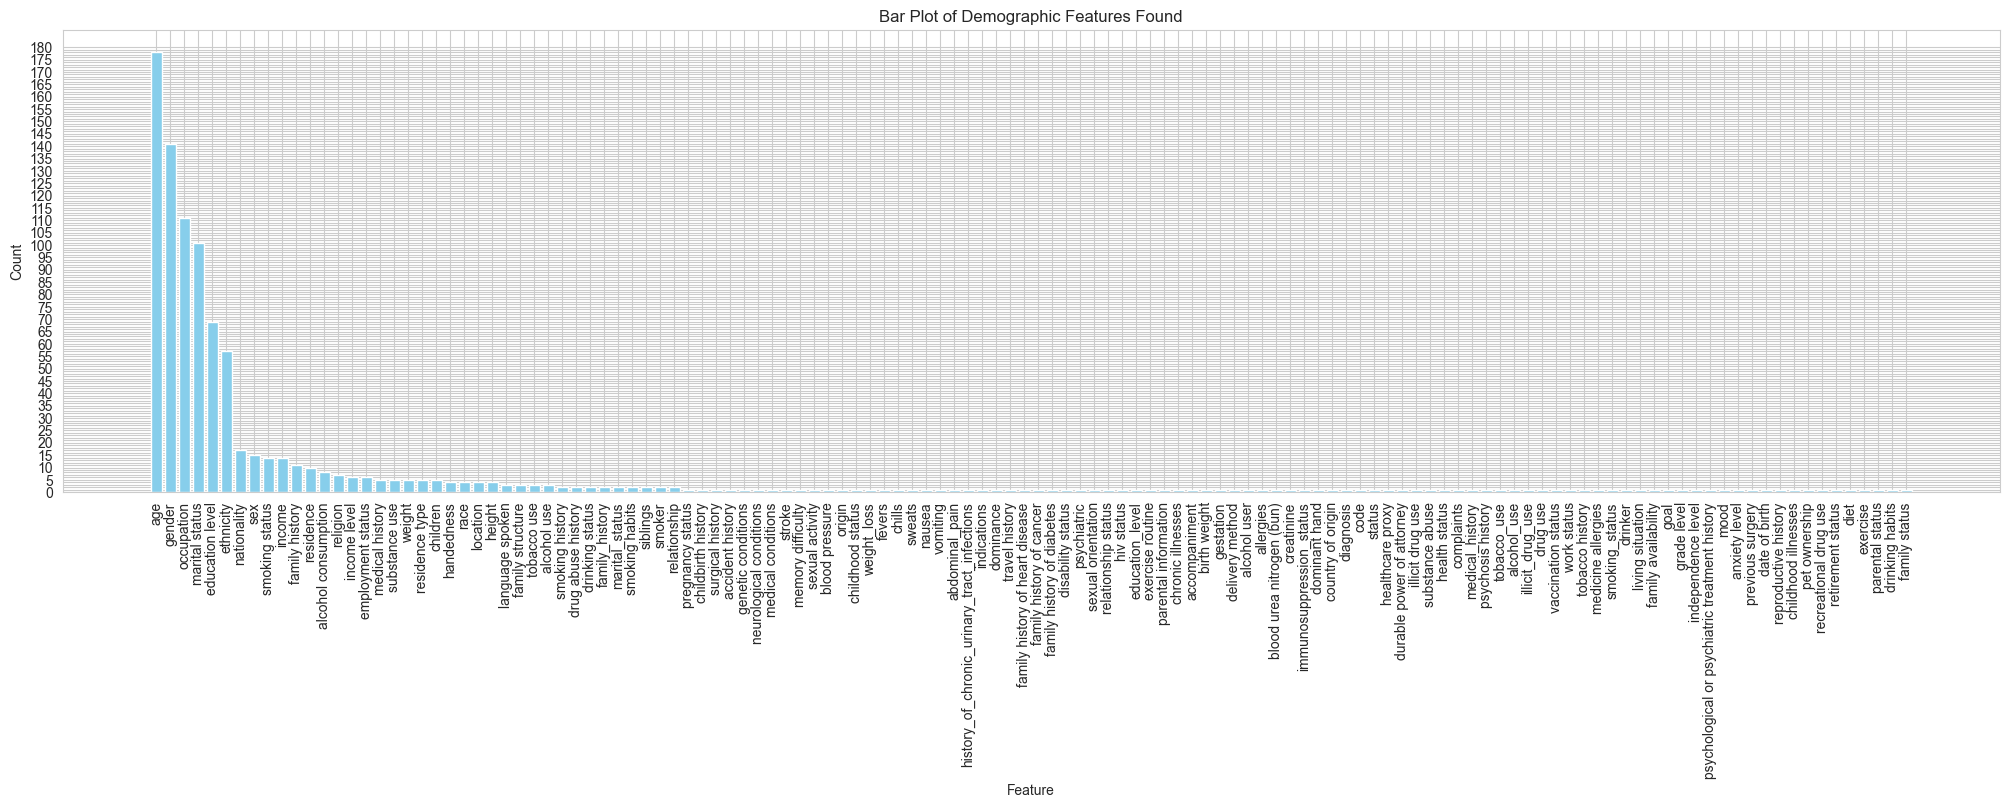

In [50]:
import matplotlib.pyplot as plt

sorted_demographic_features = dict(sorted(demographic_features.items(), key=lambda item: item[1],reverse=True))
sorted_demographic_features
keys = list(sorted_demographic_features.keys())
values = list(sorted_demographic_features.values())

# Create the plot
plt.figure(figsize=(25, 6))
plt.bar(keys, values, color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Count')
plt.title('Bar Plot of Demographic Features Found')
plt.xticks(rotation=90)
y_ticks = range(0, max(values) + 3)
y_labels = [str(tick) if tick % 5 == 0 else '' for tick in y_ticks]
plt.yticks(ticks=y_ticks, labels=y_labels)

plt.show()

In [51]:
# Select top k features based on their count
k = 6
final_demographic_features = sorted(demographic_features, key=demographic_features.get, reverse=True)[:k]
# final_demographic_features.pop(2)
final_demographic_features

['age',
 'gender',
 'occupation',
 'marital status',
 'education level',
 'ethnicity']

# Extracting features from each patient description
Features are:
- Disease Name (Srting)
- Age (number)
- Ethnicity (Srting)
- Education level (Srting)
- Marital Status (Srting)
- Occupation (Srting)
- Sex (male or female)
- Disease Severity (Srting)
- Disease treated (yes or no)
- Survival Status (alive or died)

In [56]:
prompt_text = """
You are a skilled medical professional with high capability of extracting features in structured formats.
Extract the attribute values from the patient descriptions in a JSON format. Valid attributes and their value types are 

- Disease Name
- Age (number)
- Ethnicity (Srting)
- Education level (Srting)
- Marital Status (Srting)
- Occupation (Srting)
- Sex (male or female)
- Disease Severity (Srting)
- Disease treated (yes or no)
- Survival Status (alive or died or n/a)

If an attribute is not present in the product title, the attribute value is supposed to be 'n/a'.

The patient description:
{description}
"""


prompt = PromptTemplate(
    template=prompt_text,
    input_variables=["description"],
)

feature_extractor_model = prompt | llm | JsonOutputParser()

In [58]:
outputs = []
for i, row in tqdm(mts_df.iloc[:250].iterrows()):
    output = feature_extractor_model.invoke({"description": row['section_text']})
    # print(row['section_text'])
    # print(output)
    # print("\n\n#############")
    outputs.append(output)

0it [00:00, ?it/s]

In [59]:
import pickle

# saving results, because running them again takes time.
with open('./outputfiles/mts_feature_extractor_outputs.pickle', 'wb') as f:
    pickle.dump(outputs, f, protocol=pickle.HIGHEST_PROTOCOL)



In [ ]:
import pickle

# loading results
with open('./outputfiles/mts_feature_extractor_outputs.pickle', 'rb') as f:
    outputs = pickle.load(f)

In [61]:
# Verify the Absence of Probable Additional Features Created by the Model


feature_names = [
    k for o in outputs for k in o.keys()
]
feature_names = list(set(feature_names))
feature_names

['Disease Name',
 'Age',
 'Disease treated',
 'Occupation',
 'Marital Status',
 'Ethnicity',
 'Disease Severity',
 'Survival Status',
 'Education level',
 'Sex']

# Creating DataFrame for extracted features

In [79]:
outputs_dict = {k:[] for k in feature_names}

for i, o in enumerate(outputs):
    for f in feature_names:
        if f in o.keys():
            if isinstance(o[f], str) or isinstance(o[f], int):
                outputs_dict[f].append(o[f])
            elif isinstance(o[f], list):
                outputs_dict[f].append(o[f][0])
            else: 
                print(f, o[f])
                break
        else:
            outputs_dict[f].append('n/a')
            
# for f in feature_names:
#     print(len(outputs_dict[f]))

In [124]:
outputs_df = pd.DataFrame(outputs_dict)
outputs_df.head(5)


,Disease Name,Age,Disease treated,Occupation,Marital Status,Ethnicity,Disease Severity,Survival Status,Education level,Sex
0,hypertension,76,n/a,n/a,n/a,white,stable,alive,n/a,female
1,Migraine,25,yes,n/a,n/a,Caucasian,n/a,alive,n/a,female
2,Condylomas,22,n/a,n/a,n/a,n/a,n/a,alive,n/a,female
3,n/a,n/a,no,n/a,n/a,n/a,n/a,n/a,n/a,n/a
4,Burn,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a


In [125]:
outputs_df.describe()

,Disease Name,Age,Disease treated,Occupation,Marital Status,Ethnicity,Disease Severity,Survival Status,Education level,Sex
count,250,250,250,250,250,250,250,250,250,250
unique,107,47,3,18,11,8,31,3,6,3
top,n/a,n/a,no,n/a,n/a,n/a,n/a,n/a,n/a,n/a
freq,126,191,147,230,228,239,205,147,245,142


In [126]:
for c in outputs_df.columns:
    print(c, ',', outputs_df[c].unique())
    print("##########")

Disease Name , ['hypertension' 'Migraine' 'Condylomas' 'n/a' 'Burn' 'Asthma'
 'heart disease' 'Heart disease' 'bunion deformity' 'PUD' 'RHF'
 'Pacemaker' 'Right Shoulder Pain' 'Intractable Nausea and Vomiting'
 'High Blood Pressure' 'Penicillin' 'Hypoglycemia'
 'Blood-borne pathogen exposure' 'Poison Ivy' 'Cancer' 'Calcification'
 'Chronic Urinary Tract Infections' 'CLL' 'Right knee surgery'
 'Appendectomy' 'Depression' 'PSYCHIATRIC' 'Knee Surgery' 'HIV'
 'Lymph Node Biopsy' 'Coronary Artery Disease' 'Huntington Disease' 'HTN'
 'LYMPH' 'Opioid Use Disorder' 'Schizophrenia' 'Multiple Trauma' 'MI'
 'polycythemia vera' 'Otherwise, negative' 'Diabetes type II' 'asthma'
 'Abdominal Migraine' 'Toothache' 'Chronic Knee Pain' 'Ovarian Cancer'
 'aortic stenosis' 'Cerebral Aneurysm' 'Buttock pain'
 'Left ureteral stone' 'dizziness' 'cardiac' 'chronic GVHD' 'Hypertension'
 'obesity' 'EARS' 'Shoulder Pain' 'Type II diabetes mellitus' 'BPH'
 'Diabetes' 'GASTROINTESTINAL' 'Diarrhea' 'Liver cirrhosis

Definitely these extracted feature values must be cleaned and processed:

- "Disease Name" values must be categorized into more general disease types.
- "Age" values must be cleaned. For example, a value of 1988 must be converted to `2024-1988=36`.
- "Marital Status" values must be standardized.
- "Disease Severity" values must be categorized into more well-defined types.
- "Education Level" values must be standardized.
- "Ethnicity" values must be standardized.



In [139]:
correct_values = {
    "Age": {
        1988: 36,
        '4-1/2-years posttransplant': 4,
        '2-1/2 months': 0.2,
        '40s': 40,
        'n/a': np.nan
    },
    "Marital Status": {
        'single': 'Single',
        'not married': 'Single',
        'married': 'Married',
        'monogamous': 'Married',
        'widow': 'Widow',
        'boyfriend': 'Single',
        'engaged': 'Engaged',
        'divorced': 'Divorced',
    },
    "Education level":{
        "Bachelor's degree": 'Bachelor',
        '3rd grade': 'Elementary school',
        'eleventh grade': 'High school',
        'High School or Higher': 'High school',
    },
    "Ethnicity":{
        'white':'Caucasian',  
        'right-hand dominant gentleman': 'n/a',
        'White':'Caucasian', 
        'unknown':'n/a',
    }
}

outputs_df = outputs_df.replace(correct_values)
for c in outputs_df.columns:
    print(c, ',', outputs_df[c].unique())
    print("##########")

Disease Name , ['hypertension' 'Migraine' 'Condylomas' 'n/a' 'Burn' 'Asthma'
 'heart disease' 'Heart disease' 'bunion deformity' 'PUD' 'RHF'
 'Pacemaker' 'Right Shoulder Pain' 'Intractable Nausea and Vomiting'
 'High Blood Pressure' 'Penicillin' 'Hypoglycemia'
 'Blood-borne pathogen exposure' 'Poison Ivy' 'Cancer' 'Calcification'
 'Chronic Urinary Tract Infections' 'CLL' 'Right knee surgery'
 'Appendectomy' 'Depression' 'PSYCHIATRIC' 'Knee Surgery' 'HIV'
 'Lymph Node Biopsy' 'Coronary Artery Disease' 'Huntington Disease' 'HTN'
 'LYMPH' 'Opioid Use Disorder' 'Schizophrenia' 'Multiple Trauma' 'MI'
 'polycythemia vera' 'Otherwise, negative' 'Diabetes type II' 'asthma'
 'Abdominal Migraine' 'Toothache' 'Chronic Knee Pain' 'Ovarian Cancer'
 'aortic stenosis' 'Cerebral Aneurysm' 'Buttock pain'
 'Left ureteral stone' 'dizziness' 'cardiac' 'chronic GVHD' 'Hypertension'
 'obesity' 'EARS' 'Shoulder Pain' 'Type II diabetes mellitus' 'BPH'
 'Diabetes' 'GASTROINTESTINAL' 'Diarrhea' 'Liver cirrhosis

C:\Users\Atlas\AppData\Local\Temp\ipykernel_33440\1478566695.py:33: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  outputs_df = outputs_df.replace(correct_values)


# Disease Categorization
- Since there are many diseases found in this dataset, I am going to assign them to the more general categories to which these diseases belong. A disease might be assigned to more than one category. For example, "Lung Adenocarcinoma" is assigned to ["Cancer", "Lung Cancer"].
- To determine these general categories, I received assistance from ChatGPT. I prompted ChatGPT to categorize diseases found by llama3 into general categories.



In [128]:
# These mappings are generated using ChatGPT because it is more accurate than llama3
disease_categories = [
    "Cardiovascular Diseases",
    "Neurological Disorders",
    "Infectious Diseases",
    "Cancers",
    "Respiratory Diseases",
    "Gastrointestinal Diseases",
    "Endocrine and Metabolic Disorders",
    "Musculoskeletal Disorders",
    "Psychiatric Disorders",
    "Genitourinary Disorders",
    "Skin Disorders",
    "Hematological Disorders",
    "Others"
]

categorised_diseases = {
    "hypertension": "Cardiovascular Diseases",
    "Migraine": "Neurological Disorders",
    "Condylomas": "Skin Disorders",
    "n/a": "Others",
    "Burn": "Others",
    "Asthma": "Respiratory Diseases",
    "heart disease": "Cardiovascular Diseases",
    "Heart disease": "Cardiovascular Diseases",
    "bunion deformity": "Musculoskeletal Disorders",
    "PUD": "Gastrointestinal Diseases",
    "RHF": "Cardiovascular Diseases",
    "Pacemaker": "Cardiovascular Diseases",
    "Right Shoulder Pain": "Musculoskeletal Disorders",
    "Intractable Nausea and Vomiting": "Neurological Disorders",
    "High Blood Pressure": "Cardiovascular Diseases",
    "Penicillin": "Others",
    "Hypoglycemia": "Endocrine and Metabolic Disorders",
    "Blood-borne pathogen exposure": "Infectious Diseases",
    "Poison Ivy": "Skin Disorders",
    "Cancer": "Cancers",
    "Calcification": "Others",
    "Chronic Urinary Tract Infections": "Genitourinary Disorders",
    "CLL": "Cancers",
    "Right knee surgery": "Musculoskeletal Disorders",
    "Appendectomy": "Others",
    "Depression": "Psychiatric Disorders",
    "PSYCHIATRIC": "Psychiatric Disorders",
    "Knee Surgery": "Musculoskeletal Disorders",
    "HIV": "Infectious Diseases",
    "Lymph Node Biopsy": "Others",
    "Coronary Artery Disease": "Cardiovascular Diseases",
    "Huntington Disease": "Neurological Disorders",
    "HTN": "Cardiovascular Diseases",
    "LYMPH": "Others",
    "Opioid Use Disorder": "Psychiatric Disorders",
    "Schizophrenia": "Psychiatric Disorders",
    "Multiple Trauma": "Neurological Disorders",
    "MI": "Cardiovascular Diseases",
    "polycythemia vera": "Hematological Disorders",
    "Otherwise, negative": "Others",
    "Diabetes type II": "Endocrine and Metabolic Disorders",
    "asthma": "Respiratory Diseases",
    "Abdominal Migraine": "Neurological Disorders",
    "Toothache": "Others",
    "Chronic Knee Pain": "Musculoskeletal Disorders",
    "Ovarian Cancer": "Cancers",
    "aortic stenosis": "Cardiovascular Diseases",
    "Cerebral Aneurysm": "Neurological Disorders",
    "Buttock pain": "Musculoskeletal Disorders",
    "Left ureteral stone": "Genitourinary Disorders",
    "dizziness": "Neurological Disorders",
    "cardiac": "Cardiovascular Diseases",
    "chronic GVHD": "Others",
    "Hypertension": "Cardiovascular Diseases",
    "obesity": "Endocrine and Metabolic Disorders",
    "EARS": "Skin Disorders",
    "Shoulder Pain": "Musculoskeletal Disorders",
    "Type II diabetes mellitus": "Endocrine and Metabolic Disorders",
    "BPH": "Genitourinary Disorders",
    "Diabetes": "Endocrine and Metabolic Disorders",
    "GASTROINTESTINAL": "Gastrointestinal Diseases",
    "Diarrhea": "Gastrointestinal Diseases",
    "Liver cirrhosis": "Gastrointestinal Diseases",
    "COPD exacerbation": "Respiratory Diseases",
    "Cardiovascular": "Cardiovascular Diseases",
    "non-small cell lung cancer": "Cancers",
    "Psychosis": "Psychiatric Disorders",
    "lazy eye": "Others",
    "L5-S1 lumbar laminectomy": "Musculoskeletal Disorders",
    "Hypothyroidism": "Endocrine and Metabolic Disorders",
    "thoracic kyphosis": "Musculoskeletal Disorders",
    "Dog Bite": "Others",
    "old age": "Others",
    "Borax poisoning": "Others",
    "Thyroid Goiter": "Endocrine and Metabolic Disorders",
    "left shoulder pain": "Musculoskeletal Disorders",
    "Sinusitis": "Others",
    "Disseminated intravascular coagulation": "Hematological Disorders",
    "Ureteral Stone": "Genitourinary Disorders",
    "Slipped Capital Femoral Epiphysis": "Musculoskeletal Disorders",
    "Back Pain": "Musculoskeletal Disorders",
    "INTEGUMENTARY": "Skin Disorders",
    "Parkinson's": "Neurological Disorders",
    "craniopharyngioma": "Cancers",
    "Lumbar Disc Replacement": "Musculoskeletal Disorders",
    "Abilify": "Others",
    "Upper Respiratory Infection": "Infectious Diseases",
    "pulmonary fibrosis": "Respiratory Diseases",
    "Foreign body": "Others",
    "MSK": "Musculoskeletal Disorders",
    "Calcaneal valgus deformity": "Musculoskeletal Disorders",
    "Refracture": "Musculoskeletal Disorders",
    "Reproductive Hx": "Others",
    "Hypothermia": "Others",
    "Stomatitis": "Skin Disorders",
    "noncontributory": "Others",
    "uterine papillary serous carcinoma": "Cancers",
    "Acoustic Neuroma": "Neurological Disorders",
    "atrial fibrillation": "Cardiovascular Diseases",
    "Hepatitis C": "Infectious Diseases",
    "Myocardial Infarction": "Cardiovascular Diseases",
    "Bilateral knee DJD": "Musculoskeletal Disorders",
    "brain tumor": "Cancers",
    "Gastroesophageal Reflux Disease": "Gastrointestinal Diseases",
    "Hemorrhoids": "Gastrointestinal Diseases",
    "Hydrocephalus": "Neurological Disorders",
    "colon cancer": "Cancers"
}


In [129]:
for c in disease_categories:
    outputs_df[c] = np.zeros(outputs_df.shape[0])

outputs_df['Disease Type'] = ['n/a'] * outputs_df.shape[0]
for i, row in outputs_df.iterrows():
    disease = row['Disease Name']
    outputs_df.loc[i, 'Disease Type'] = 'n/a'
    if disease == 'n/a':
        continue

    category = categorised_diseases[disease]
    outputs_df.loc[i, 'Disease Type'] = category
    outputs_df.loc[i, category] = 1
    
    

In [130]:
# Double check if there is any unassigned disease

outputs_df['Disease Name'][outputs_df[disease_categories].sum(axis=1) == 0].unique()

array(['n/a'], dtype=object)

# Disease Severity Categorization

I will categorize each disease severity identified by the model into one of the following groups: 
- Mild
- Moderate
- Severe
- Variable
- Other

These categories and mapping into categories are done by ChatGPT. I prompted ChatGPT to categorize each disease severity found by llama3 into general categories.

In [131]:
severity_categories = [
    "Mild",
    "Moderate",
    "Severe",
    "Variable",
    "Other",
]

categorised_severities = {
    "stable": "Mild",
    "worsening": "Severe",
    "Persistent": "Moderate",
    "unremarkable": "Mild",
    "Moderate": "Moderate",
    "Srting": "Other",  # Assuming a typo, no clear category
    "mild to moderate": "Moderate",
    "decreased consciousness": "Severe",
    "Normal": "Mild",
    "complications": "Severe",
    "mild": "Mild",
    "poorly controlled": "Severe",
    "moderate to severe": "Severe",
    "progressively worse and more painful": "Severe",
    "chronic": "Moderate",
    "unbearable": "Severe",
    "questionable cancer": "Variable",
    "9/10": "Severe",
    "acute on chronic": "Variable",
    "stage IA": "Variable",
    "resolved": "Mild",
    "significant": "Moderate",
    "Severe": "Severe",
    "negative": "Mild",
    "some residual disease": "Moderate",
    "High": "Severe",
    "Mild": "Mild",
    "complicated": "Severe",
    "Not painful": "Mild",
    "under good control": "Mild"
}


In [132]:
for c in severity_categories:
    outputs_df[c] = np.zeros(outputs_df.shape[0])

for i, row in outputs_df.iterrows():
    severity = row['Disease Severity']
    if severity == 'n/a':
        continue
        
    category = categorised_severities[severity]
    outputs_df.loc[i, category] = 1


In [118]:
outputs_df.head()

,Disease Name,Age,Disease treated,Occupation,Marital Status,Ethnicity,Disease Severity,Survival Status,Education level,Sex,...,Genitourinary Disorders,Skin Disorders,Hematological Disorders,Others,Mild,Moderate,Severe,Variable,Other,Disease Type
0,hypertension,76,n/a,n/a,n/a,Caucasian,stable,alive,n/a,female,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Cardiovascular Diseases
1,Migraine,25,yes,n/a,n/a,Caucasian,n/a,alive,n/a,female,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological Disorders
2,Condylomas,22,n/a,n/a,n/a,n/a,n/a,alive,n/a,female,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Skin Disorders
3,n/a,n/a,no,n/a,n/a,n/a,n/a,n/a,n/a,n/a,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,n/a
4,Burn,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Others


# plotting population distribution for each feature:


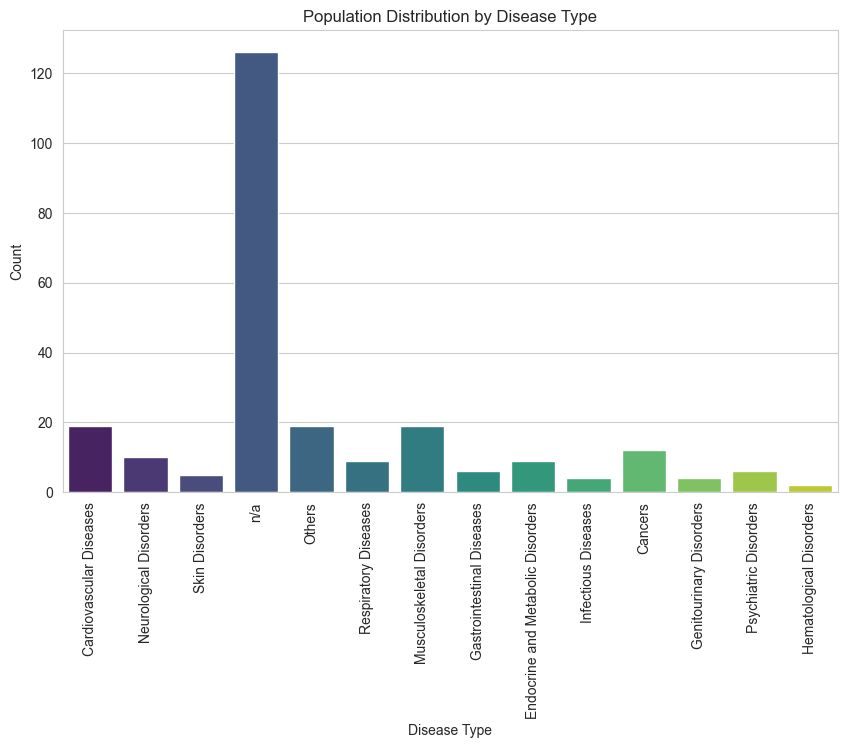

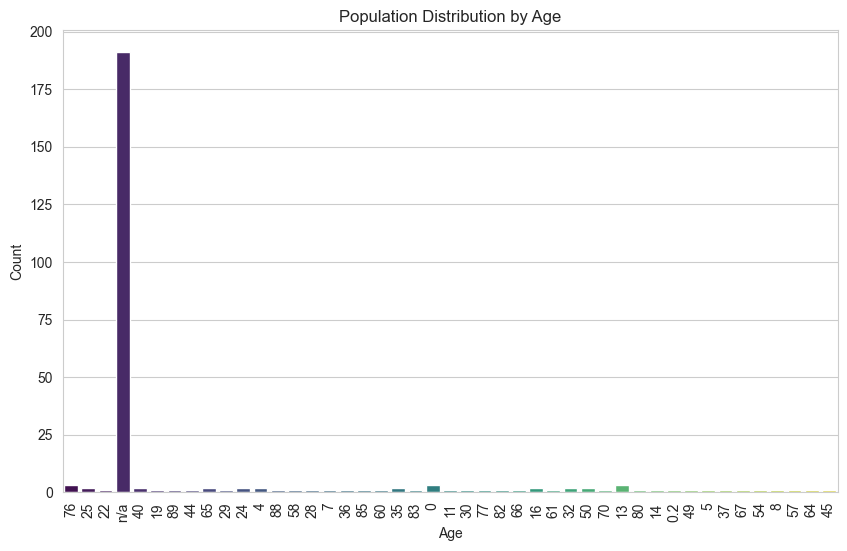

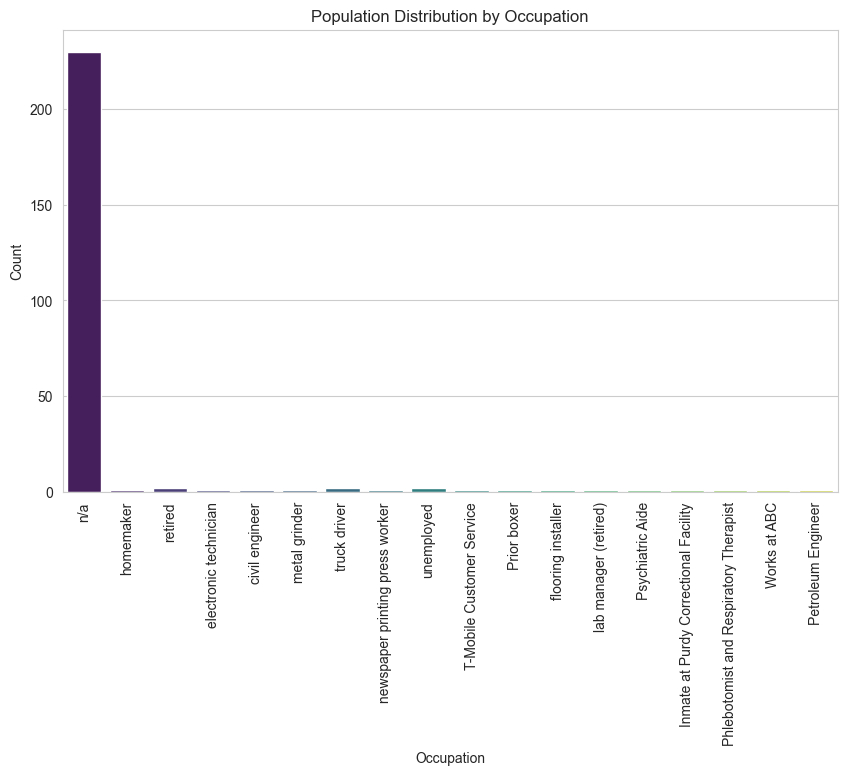

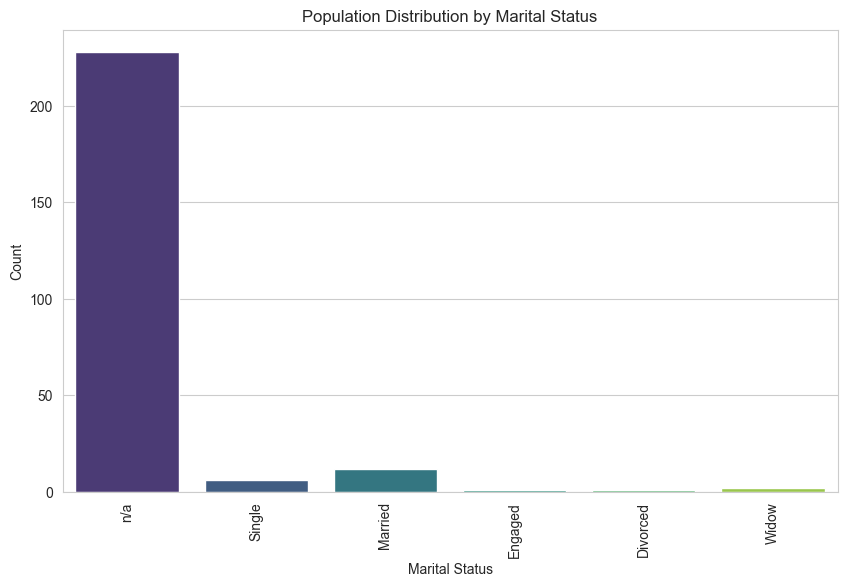

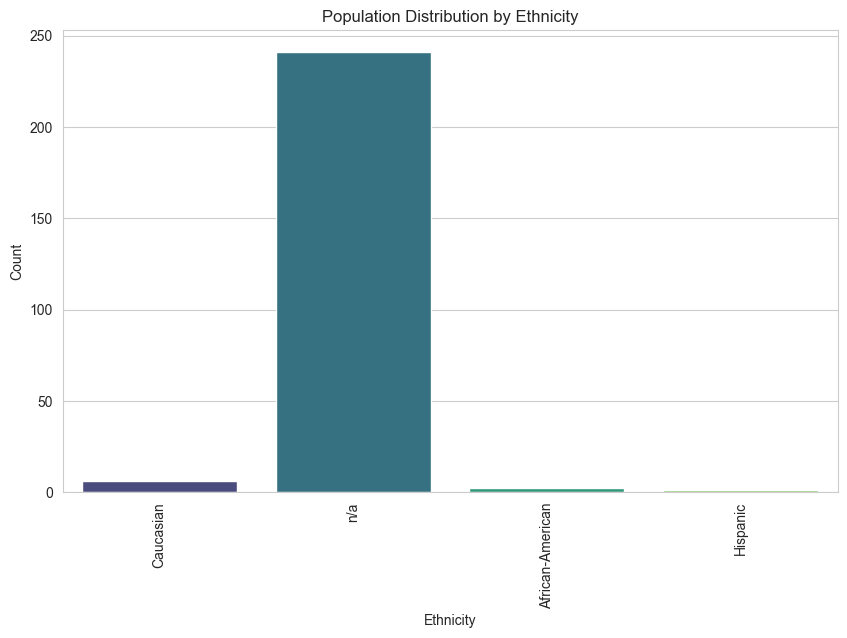

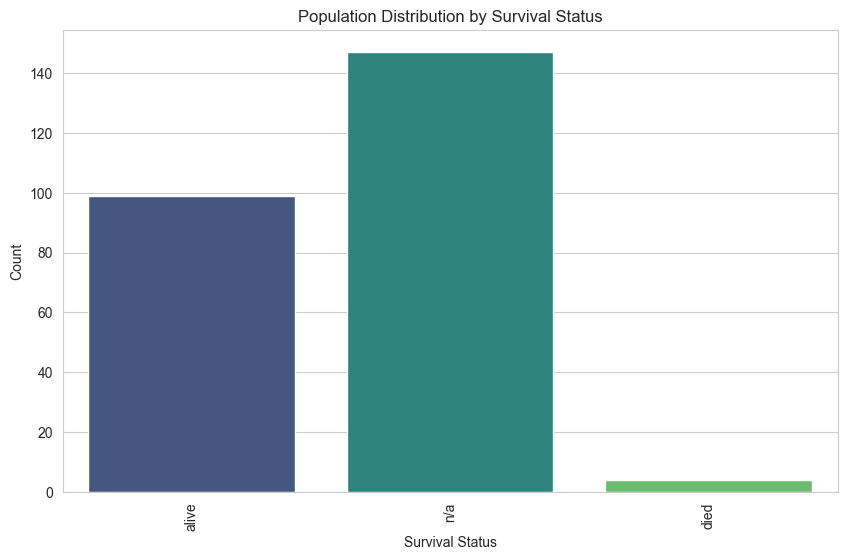

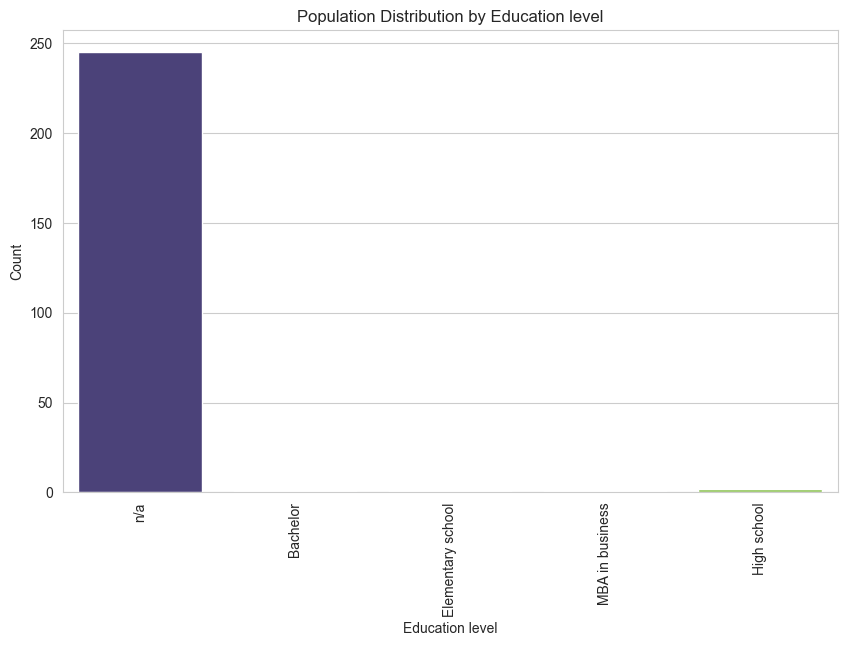

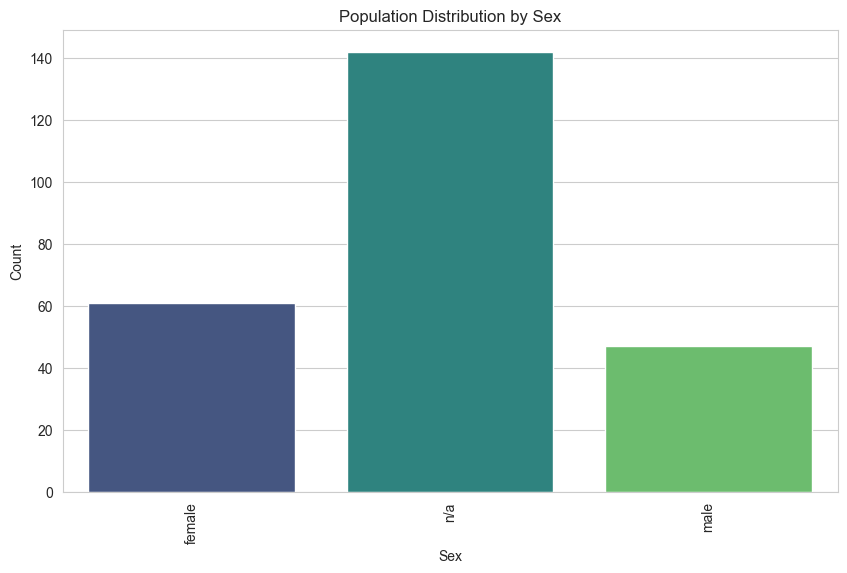

In [133]:
import seaborn as sns

# Function to create and show plots
def plot_population_distribution(df, columns):
    for column in columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x=column, hue=column, palette='viridis', dodge=False, legend=False)
        plt.title(f'Population Distribution by {column}')
        plt.xticks(rotation=90)
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.show()

# List of features to plot
target_plot_features = ['Disease Type', 'Age', 'Occupation', 'Marital Status', 'Ethnicity', 'Survival Status', 'Education level', 'Sex']

# Plotting the distributions
plot_population_distribution(outputs_df, target_plot_features)

# Query These:
- For each disease column, plot all severities bar plot
- For each disease column, plot age population
- For each disease column, plot occupation population
- For each disease column plot Survival bar plot and calculate the rate of survival (ignore n/a values)
- For each disease column plot treatment  bar plot  and rate of treatment (ignore n/a values)
- For each disease column plot ethnicity  bar plot 
- For each disease column plot gender  bar plot
- For each disease column calculate rate of survival for each gender.
- Fore each disease column calculate rate of treatment for each gender.
- For each disease column calculate rate of survival for each age.
- For each disease column calculate rate of treatment for each age






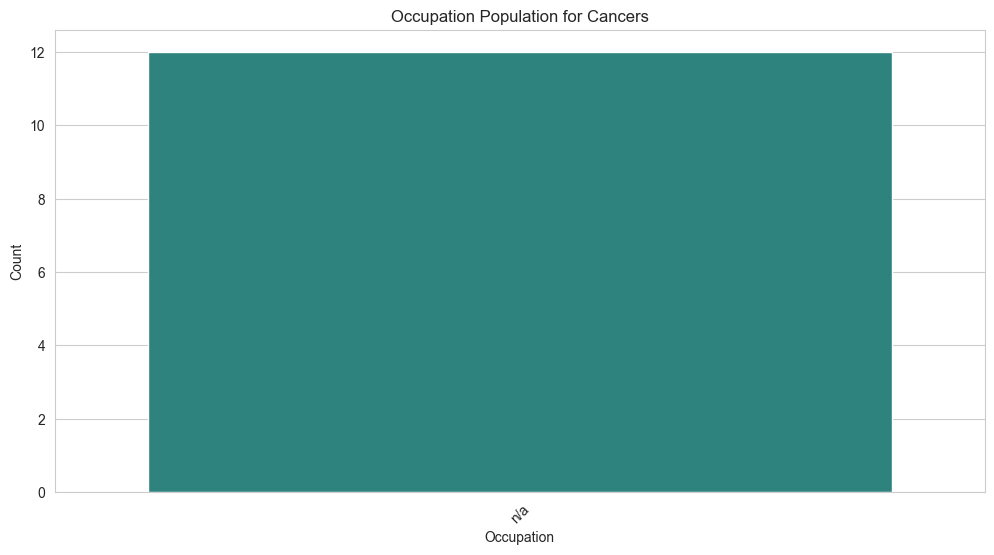

In [156]:
# Function to plot severity bar plot
def plot_severity(df, disease):
    severities = [
            "Mild",
            "Moderate",
            "Severe",
            "Variable",
            "Other",
        ]
    severity_counts = df[df[disease] == 1][severities].sum()
    severity_counts.plot(kind='bar', title=f'{disease} Severities')
    plt.ylabel('Count')
    plt.show()

# Function to plot occupation population for a specific disease
def plot_occupation(df, disease):
    disease_data = df[df[disease] == 1]
    occupation_counts = disease_data['Occupation'].value_counts().reset_index()
    occupation_counts.columns = ['Occupation', 'Count']
    plt.figure(figsize=(12, 6))
    sns.barplot(data=occupation_counts, x='Occupation', y='Count', hue='Occupation', dodge=False, palette='viridis', legend=False)
    plt.title(f'Occupation Population for {disease}')
    plt.xlabel('Occupation')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()
    
# Function to plot age population
def plot_age_population(df, disease):
    data = df[df[disease] == 1]['Age']
    plt.figure(figsize=(10, 6))
    ax = sns.histplot(data, bins=10, kde=False)
    ax.set_title(f'{disease} Age Population')
    ax.set_xlabel('Age')
    ax.set_ylabel('Count')
    
    # Adding x-axis values on top of bars if y-axis value > 0
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            # x-position is the center of the bar
            x = p.get_x() + p.get_width() / 2
            # get the bin range
            bin_range = f'{int(p.get_x())}-{int(p.get_x() + p.get_width())}'
            ax.annotate(f'{bin_range}', (x, height), ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')
    
    plt.show()


# Function to plot survival bar plot and calculate survival rate
def plot_survival(df, disease):
    survival_counts = df[df[disease] == 1]['Survival Status'].value_counts()
    survival_counts.plot(kind='bar', title=f'{disease} Survival Status')
    plt.ylabel('Count')
    plt.show()
    
    survival_rate = survival_counts['alive'] / survival_counts.sum() if 'alive' in survival_counts else 0
    print(f'Survival rate for {disease}: {survival_rate:.2f}')

# Function to plot treatment bar plot and calculate treatment rate
def plot_treatment(df, disease):
    treatment_counts = df[df[disease] == 1]['Disease treated'].value_counts()
    treatment_counts.plot(kind='bar', title=f'{disease} Treatment Status')
    plt.ylabel('Count')
    plt.show()
    
    treatment_rate = treatment_counts['yes'] / treatment_counts.sum() if 'yes' in treatment_counts else 0
    print(f'Treatment rate for {disease}: {treatment_rate:.2f}')

# Function to plot ethnicity bar plot
def plot_ethnicity(df, disease):
    ethnicity_counts = df[df[disease] == 1]['Ethnicity'].value_counts()
    ethnicity_counts.plot(kind='bar', title=f'{disease} Ethnicity Distribution')
    plt.ylabel('Count')
    plt.show()

# Function to plot gender bar plot
def plot_gender(df, disease):
    gender_counts = df[df[disease] == 1]['Sex'].value_counts()
    gender_counts.plot(kind='bar', title=f'{disease} Gender Distribution')
    plt.ylabel('Count')
    plt.show()

# Function to calculate rate of survival for each gender
def survival_rate_by_gender(df, disease):
    survival_gender = df[df[disease] == 1].groupby('Sex')['Survival Status'].value_counts(normalize=True).unstack()
    print(f'Survival rate by gender for {disease}:\n', survival_gender)

# Function to calculate rate of treatment for each gender
def treatment_rate_by_gender(df, disease):
    treatment_gender = df[df[disease] == 1].groupby('Sex')['Disease treated'].value_counts(normalize=True).unstack()
    print(f'Treatment rate by gender for {disease}:\n', treatment_gender)

# Function to calculate rate of survival for each age
def survival_rate_by_age(df, disease):
    survival_age = df[df[disease] == 1].groupby('Age')['Survival Status'].value_counts(normalize=True).unstack()
    print(f'Survival rate by age for {disease}:\n', survival_age)

# Function to calculate rate of treatment for each age
def treatment_rate_by_age(df, disease):
    treatment_age = df[df[disease] == 1].groupby('Age')['Disease treated'].value_counts(normalize=True).unstack()
    print(f'Treatment rate by age for {disease}:\n', treatment_age)


plot_occupation(outputs_df, 'Cancers')

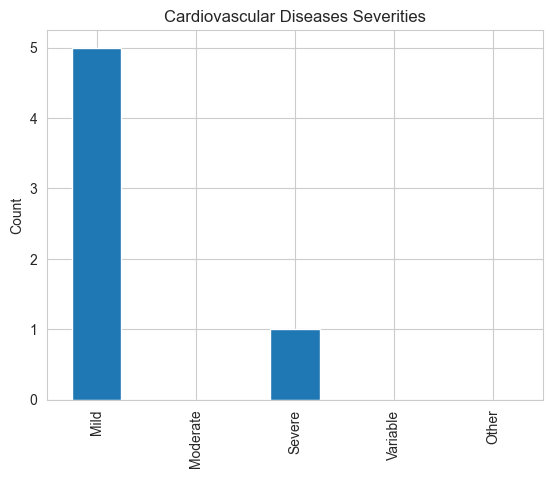

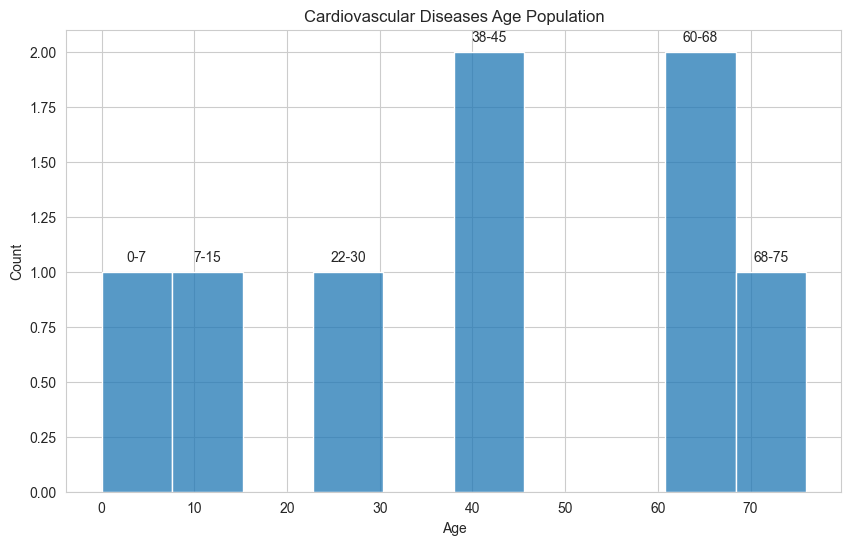

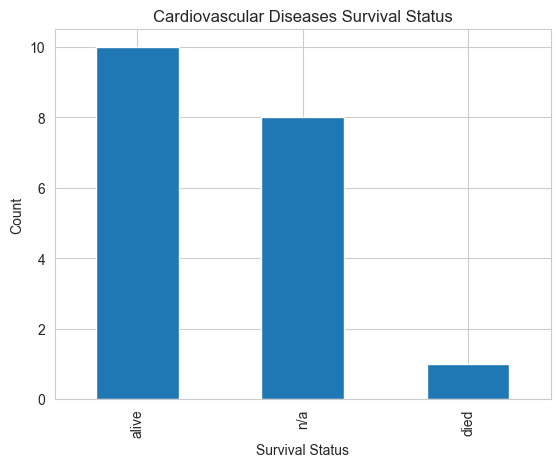

Survival rate for Cardiovascular Diseases: 0.53


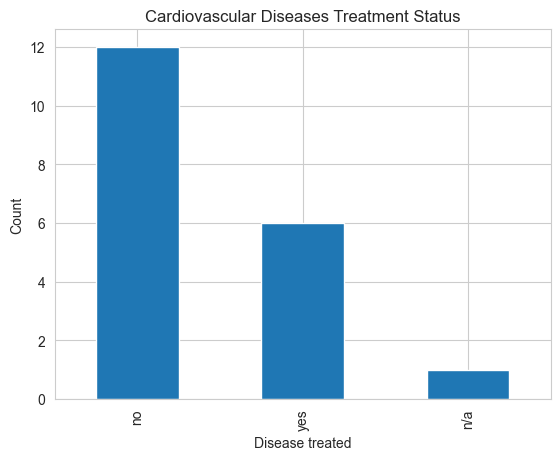

Treatment rate for Cardiovascular Diseases: 0.32


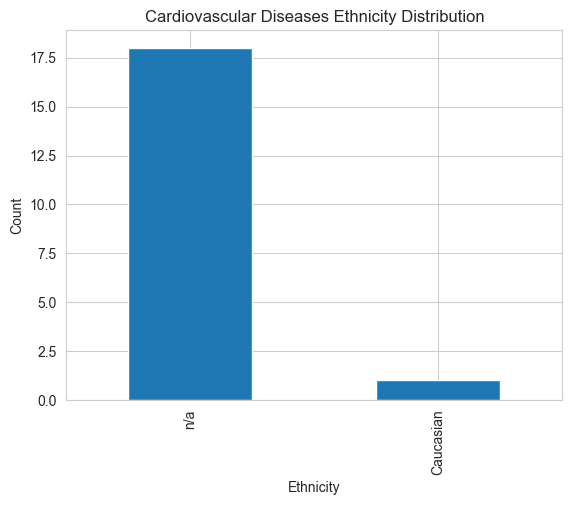

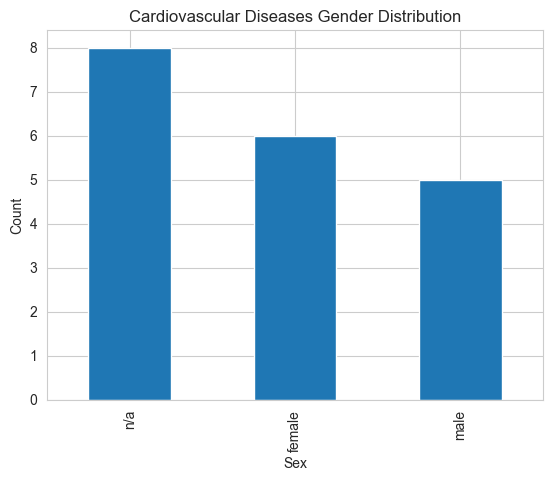

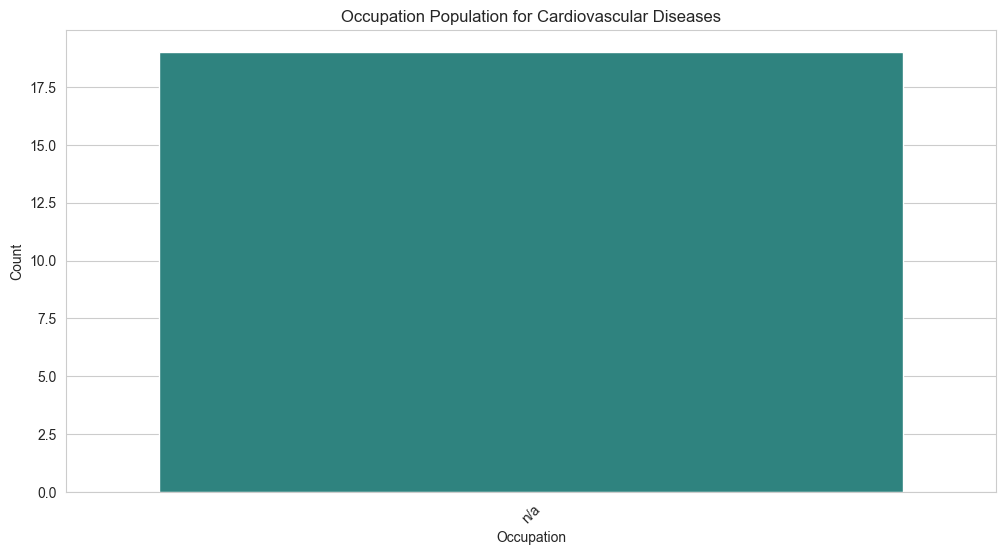

Survival rate by gender for Cardiovascular Diseases:
 Survival Status     alive      died       n/a
Sex                                          
female           0.666667  0.166667  0.166667
male             0.800000       NaN  0.200000
n/a              0.250000       NaN  0.750000
Treatment rate by gender for Cardiovascular Diseases:
 Disease treated       n/a        no       yes
Sex                                          
female           0.166667  0.666667  0.166667
male                  NaN  0.600000  0.400000
n/a                   NaN  0.625000  0.375000
Survival rate by age for Cardiovascular Diseases:
 Survival Status  alive  died  n/a
Age                              
0.0                NaN   NaN  1.0
8.0                1.0   NaN  NaN
25.0               1.0   NaN  NaN
40.0               1.0   NaN  NaN
44.0               1.0   NaN  NaN
65.0               0.5   0.5  NaN
76.0               1.0   NaN  NaN
Treatment rate by age for Cardiovascular Diseases:
 Disease treated  n/a  

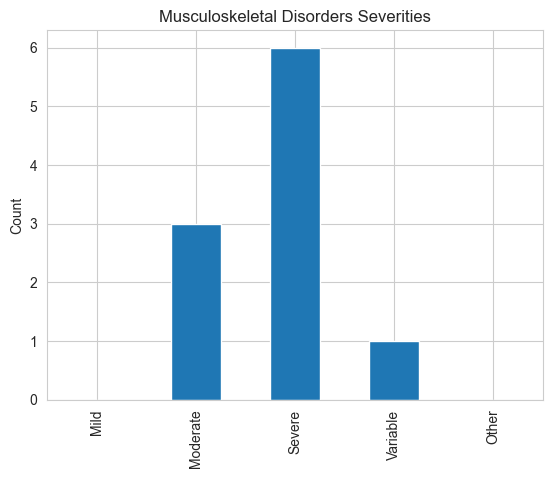

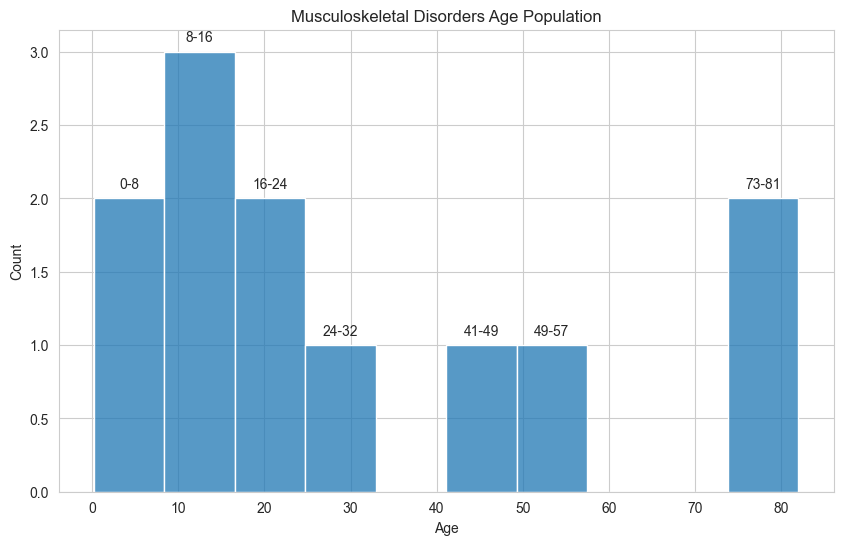

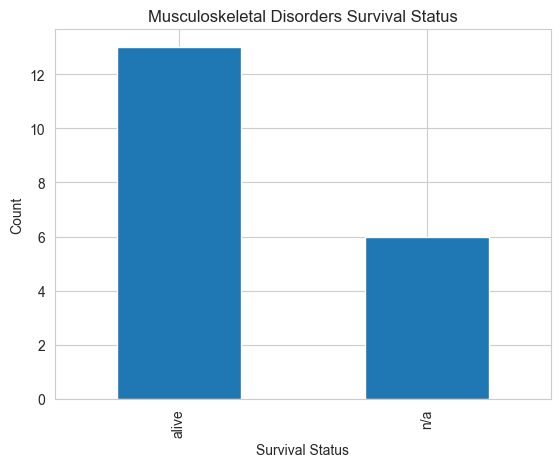

Survival rate for Musculoskeletal Disorders: 0.68


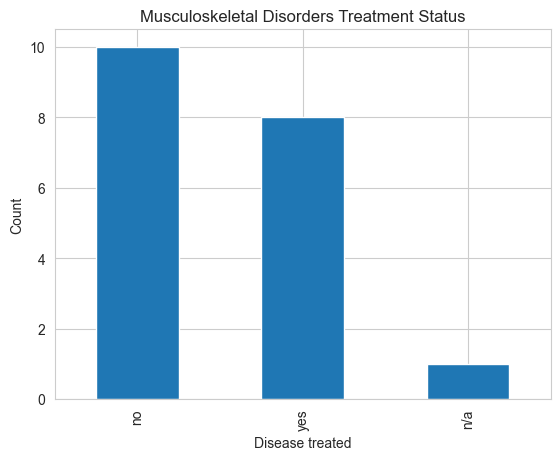

Treatment rate for Musculoskeletal Disorders: 0.42


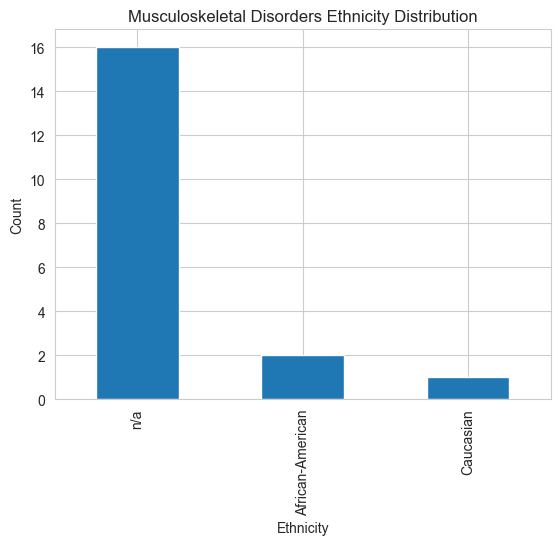

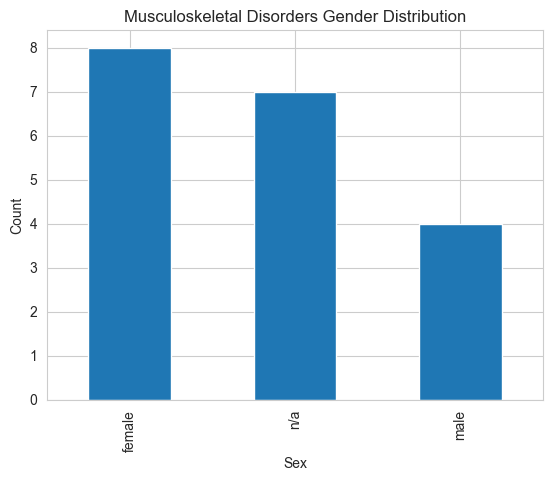

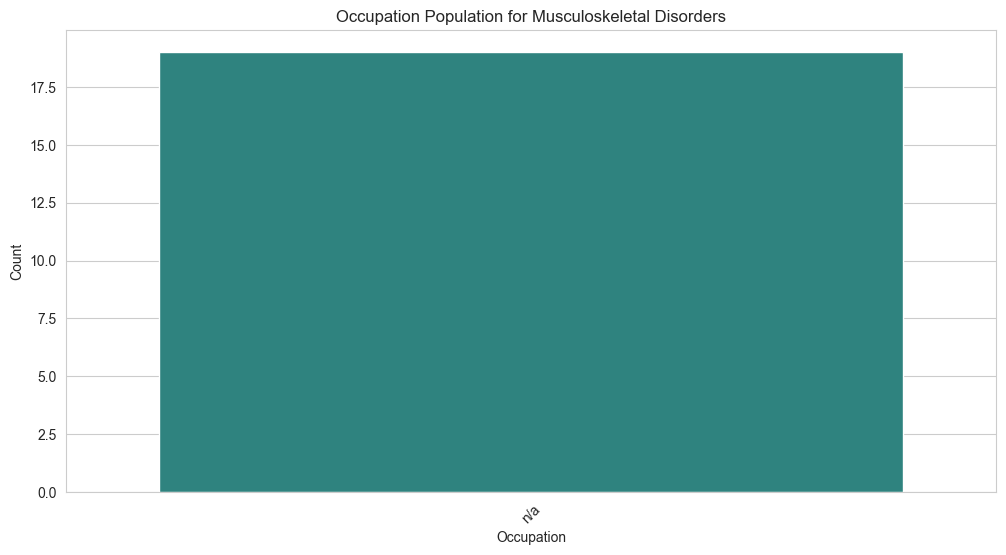

Survival rate by gender for Musculoskeletal Disorders:
 Survival Status     alive       n/a
Sex                                
female           0.875000  0.125000
male             1.000000       NaN
n/a              0.285714  0.714286
Treatment rate by gender for Musculoskeletal Disorders:
 Disease treated       n/a        no       yes
Sex                                          
female                NaN  0.750000  0.250000
male                  NaN  0.250000  0.750000
n/a              0.142857  0.428571  0.428571
Survival rate by age for Musculoskeletal Disorders:
 Survival Status  alive  n/a
Age                        
0.2                1.0  NaN
5.0                1.0  NaN
13.0               1.0  NaN
19.0               NaN  1.0
24.0               1.0  NaN
29.0               1.0  NaN
49.0               1.0  NaN
57.0               1.0  NaN
77.0               1.0  NaN
82.0               1.0  NaN
Treatment rate by age for Musculoskeletal Disorders:
 Disease treated       yes        n

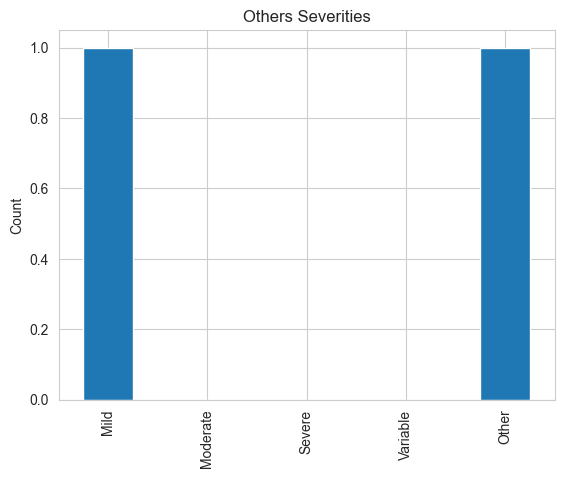

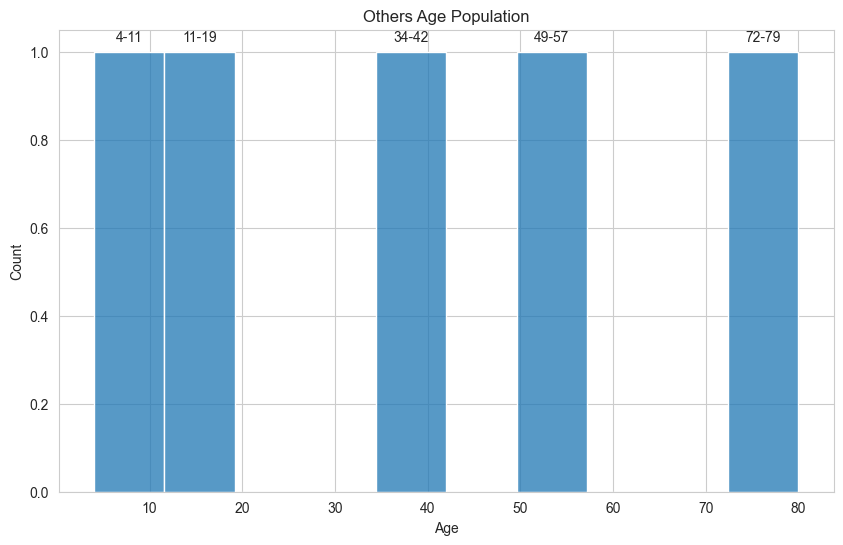

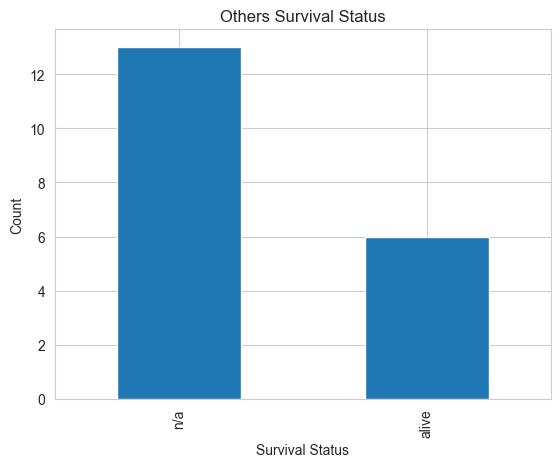

Survival rate for Others: 0.32


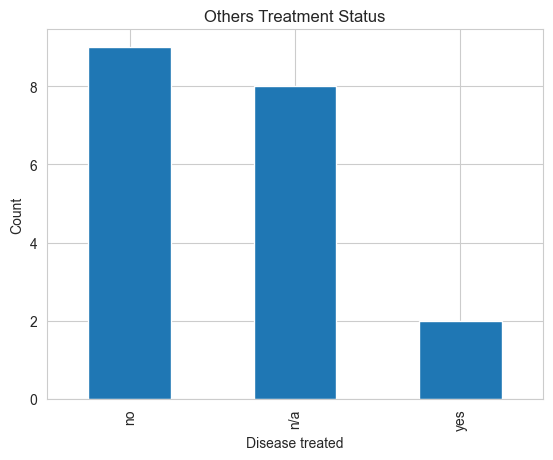

Treatment rate for Others: 0.11


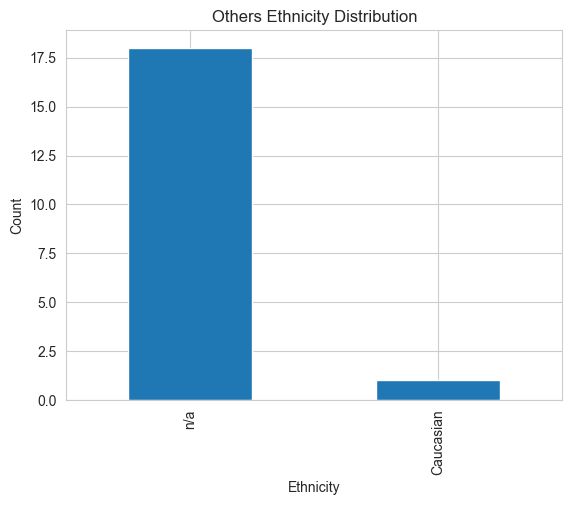

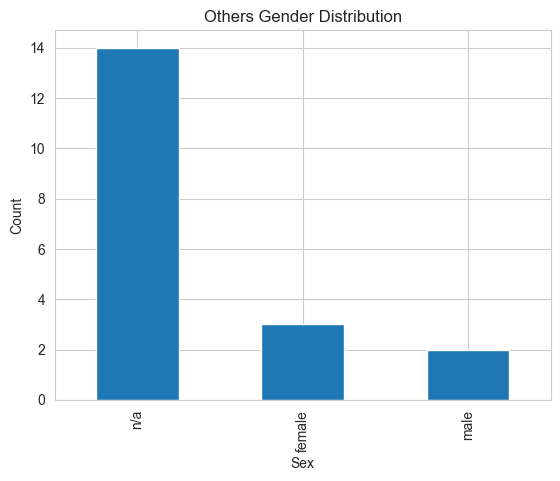

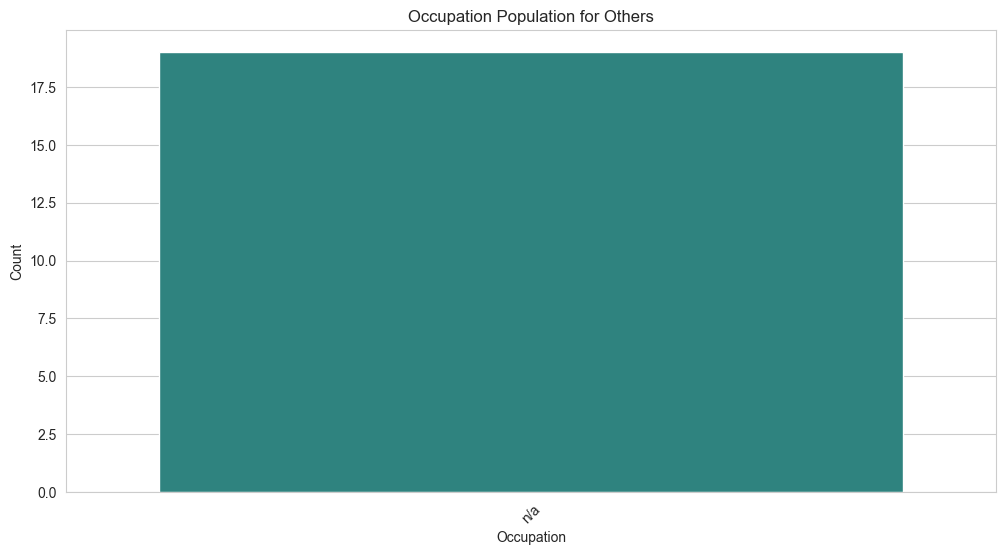

Survival rate by gender for Others:
 Survival Status     alive       n/a
Sex                                
female           0.666667  0.333333
male             1.000000       NaN
n/a              0.142857  0.857143
Treatment rate by gender for Others:
 Disease treated       n/a        no       yes
Sex                                          
female           0.333333  0.666667       NaN
male                  NaN  0.500000  0.500000
n/a              0.500000  0.428571  0.071429
Survival rate by age for Others:
 Survival Status  alive
Age                   
4.0                1.0
14.0               1.0
36.0               1.0
50.0               1.0
80.0               1.0
Treatment rate by age for Others:
 Disease treated   no  yes
Age                      
4.0              1.0  NaN
14.0             1.0  NaN
36.0             NaN  1.0
50.0             NaN  1.0
80.0             1.0  NaN


In [157]:
# Run above functions for top 3 disease in terms of their count.

# Function to find top k diseases based on their counts
def find_top_k_diseases(df, disease_columns, k):
    # Calculate the sum for each disease column
    disease_counts = df[disease_columns].sum().sort_values(ascending=False)
    
    # Get the top k diseases
    top_k_diseases = disease_counts.head(k)
    
    return list(top_k_diseases.index)

k = 3
top_k_diseases = find_top_k_diseases(outputs_df, disease_categories, k)

functions = [
    plot_severity,
    plot_age_population,
    plot_survival,
    plot_treatment,
    plot_ethnicity,
    plot_gender,
    plot_occupation,
    survival_rate_by_gender,
    treatment_rate_by_gender,
    survival_rate_by_age,
    treatment_rate_by_age,
]

for disease in top_k_diseases:
    for f in functions:
        f(outputs_df,  disease)

In [159]:
outputs_df.to_csv("outputfiles/mts_df.csv", index=False)